In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


```{bash}
$ zcat firth-default/ukb24983_v2_hg19.HC382.log.gz | python plink2_runtime_seconds.py /dev/stdin
174119

$ zcat firth-residualize/ukb24983_v2_hg19.HC382.log.gz | python plink2_runtime_seconds.py /dev/stdin
57722

$ zcat cc-residualize/ukb24983_v2_hg19.HC382.log.gz | python plink2_runtime_seconds.py /dev/stdin
26047
```


In [167]:
timing_df <- data.frame(
    method = c(
        'firth-fallback (default)',
        'w/ firth-residualize',
        'w/ firth-residualize cc-residualize'
    ),
    time = c(
        174119,
        57722,
        26047
    )
)

In [202]:
p0_timing <- timing_df %>%
ggplot(aes(x = reorder(as.factor(method), time), y = (2 * time / 3600))) +
geom_bar(stat="identity") +
geom_text(aes(label=round(2 * time / 3600, 1)), hjust = 1.1, vjust=1.8, color="white", size=5)+
coord_flip() +
theme_bw() +
labs(
    title='Runtime comparison of Firth logistic regression with plink2',
    y = 'Total run time [hours] (single-thread)',
    x = 'plink2 --glm modifier'
)

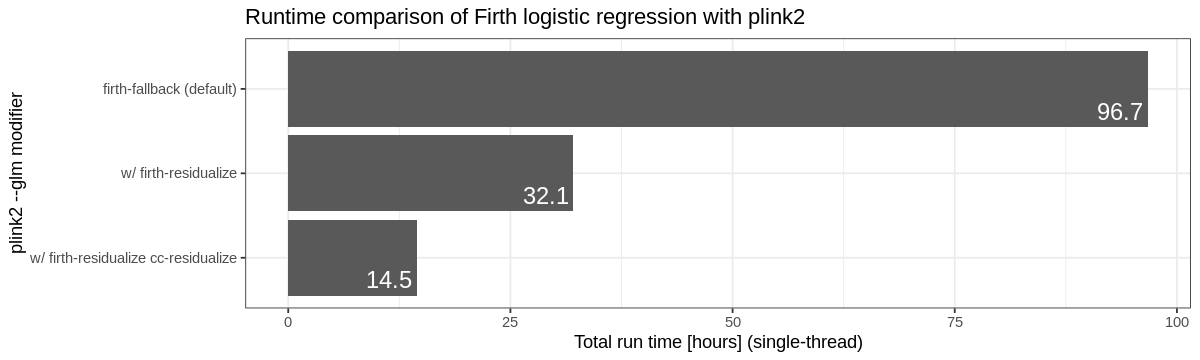

In [203]:
options(repr.plot.width=10, repr.plot.height=3)
p0_timing

In [204]:
ggsave(
    'p0.time.png',
    p0_timing,
    width=10, height=3
)

In [70]:
# input files

in_f1 <- 'firth-default/ukb24983_v2_hg19.HC382.glm.logistic.hybrid.gz'
in_f2 <- 'cc-residualize/ukb24983_v2_hg19.HC382.glm.logistic.hybrid.gz'


In [71]:
read_logit <- function(in_f){
    # read the logit output files
    in_f %>%
    fread() %>%
    rename('CHROM'='#CHROM') %>%
    mutate(BETA = log(OR), log10P=-log10(P))
}


## read summary statistics files


In [72]:
in_f1 %>% read_logit() -> df1
in_f2 %>% read_logit() -> df2


## check the error code

The two runs may have different sets of unfinished variants


In [114]:
df1 %>% count(ERRCODE=='.')


"ERRCODE == "".""",n
<lgl>,<int>
FALSE,84574
TRUE,996394


In [113]:
df2 %>% count(ERRCODE=='.')

"ERRCODE == "".""",n
<lgl>,<int>
FALSE,82716
TRUE,998252


## Join the two summary statistics into one data frame

In [94]:
inner_join(
    df1 %>% 
    select(ID, BETA, log10P, `LOG(OR)_SE`, `FIRTH?`, ERRCODE) %>%
    rename('BETA_1' = 'BETA', 'log10P_1'='log10P', 'SE_1'='LOG(OR)_SE', 'FIRTH_1'='FIRTH?', 'ERRCODE_1'='ERRCODE'),
    
    df2 %>% 
    select(ID, BETA, log10P, `LOG(OR)_SE`, `FIRTH?`, ERRCODE) %>%
    rename('BETA_2' = 'BETA', 'log10P_2'='log10P', 'SE_2'='LOG(OR)_SE', 'FIRTH_2'='FIRTH?', 'ERRCODE_2'='ERRCODE'),
    
    by='ID'
    
) %>%
mutate(
    is_sig_1 = (log10P_1 > -log10(5e-8)),
    is_sig_2 = (log10P_2 > -log10(5e-8))
) -> df


## check the error codes

In [117]:
df %>%
count(ERRCODE_1 == ERRCODE_2)


ERRCODE_1 == ERRCODE_2,n
<lgl>,<int>
FALSE,4805
TRUE,1076163


In [95]:
df %>%
filter(ERRCODE_1 != ERRCODE_2) %>%
count(ERRCODE_1, ERRCODE_2) %>%
arrange(-n)


ERRCODE_1,ERRCODE_2,n
<chr>,<chr>,<int>
UNFINISHED,.,3036
.,UNFINISHED,1473
FIRTH_CONVERGE_FAIL,.,295
FIRTH_CONVERGE_FAIL,UNFINISHED,1


## Error code and `Firth?` status

`firth-residualize` and `cc-residualize` are the options for Firth and non-Firth regression runs.
Let's see how the counts look like.


In [100]:
df %>%
filter(ERRCODE_1 == '.' | ERRCODE_2 == '.') %>%
count(FIRTH_1, FIRTH_2, ERRCODE_1, ERRCODE_2) %>%
arrange(-n)


FIRTH_1,FIRTH_2,ERRCODE_1,ERRCODE_2,n
<chr>,<chr>,<chr>,<chr>,<int>
N,N,.,.,807622
Y,Y,.,.,186922
Y,Y,UNFINISHED,.,3027
Y,Y,.,UNFINISHED,1464
N,Y,.,.,377
Y,N,FIRTH_CONVERGE_FAIL,.,203
Y,Y,FIRTH_CONVERGE_FAIL,.,92
N,N,UNFINISHED,.,9
N,Y,.,UNFINISHED,9


## Check whether we identify the same set of significant (p < 5e-8) associations

In [103]:
df %>%
filter(ERRCODE_1 == '.' | ERRCODE_2 == '.') %>%
count(is_sig_1, is_sig_2, ERRCODE_1, ERRCODE_2) %>%
arrange(-n)


is_sig_1,is_sig_2,ERRCODE_1,ERRCODE_2,n
<lgl>,<lgl>,<chr>,<chr>,<int>
FALSE,FALSE,.,.,992999
FALSE,FALSE,UNFINISHED,.,3036
TRUE,TRUE,.,.,1914
FALSE,FALSE,.,UNFINISHED,1472
NA,FALSE,FIRTH_CONVERGE_FAIL,.,295
TRUE,FALSE,.,.,8
FALSE,TRUE,.,UNFINISHED,1


Those two runs are mostly consistent with exception of 9 variants.

In [106]:
df %>%
filter(ERRCODE_1 == '.' | ERRCODE_2 == '.') %>%
filter((is_sig_1 | is_sig_2) & (! (is_sig_1 & is_sig_2)))

ID,BETA_1,log10P_1,SE_1,FIRTH_1,ERRCODE_1,BETA_2,log10P_2,SE_2,FIRTH_2,ERRCODE_2,is_sig_1,is_sig_2
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<lgl>
rs2215942,0.03999926,7.304276,0.00733498,N,.,0.03995122,7.300903,0.00732908,N,.,TRUE,FALSE
rs9264955,0.06541314,7.429323,0.01188480,N,.,0.06311563,7.174149,0.01168910,N,.,TRUE,FALSE
rs2428499,0.04579521,7.441240,0.00831399,N,.,0.04430393,7.226124,0.00817371,N,.,TRUE,FALSE
rs9268460,0.04253253,7.421496,0.00773315,N,.,0.04112275,7.202232,0.00760042,N,.,TRUE,FALSE
rs9271413,0.06007859,7.329692,0.01099710,N,.,0.05825004,7.178339,0.01078470,N,.,TRUE,FALSE
Affx-92039945,0.06366939,7.378185,0.01161170,N,.,0.06108569,7.065421,0.01140970,N,.,TRUE,FALSE
rs7969196,-0.04310063,7.311042,0.00790045,N,.,-0.04163587,7.089991,0.00776173,N,.,TRUE,FALSE
rs4775297,0.04311696,7.409728,0.00784520,N,.,0.04177514,7.222315,0.00770964,N,.,TRUE,FALSE
rs80357502,-2.40820009,1.009723,1.45451000,Y,.,-117.76101626,7.598932,21.13440000,Y,UNFINISHED,FALSE,TRUE


`rs80357502` has a wildly different estimates (with `UNFINISHED` status).

## BETA vs BETA for the other 8 variants

In [118]:
p1_8_vars_BETA_vs_BETA <- df %>%
filter(ERRCODE_1 == '.', ERRCODE_2 == '.') %>%
filter((is_sig_1 | is_sig_2) & (! (is_sig_1 & is_sig_2))) %>%
ggplot(aes(x = BETA_1, y= BETA_2)) +
geom_abline(slope = 1, intercept=0, color='gray')+
geom_errorbarh(aes(xmin = BETA_1 - SE_1, xmax = BETA_1 + SE_1), alpha=.5) +
geom_errorbar( aes(ymin = BETA_2 - SE_2, ymax = BETA_2 + SE_2), alpha=.5) +
geom_point(alpha=.5) +
theme_bw()

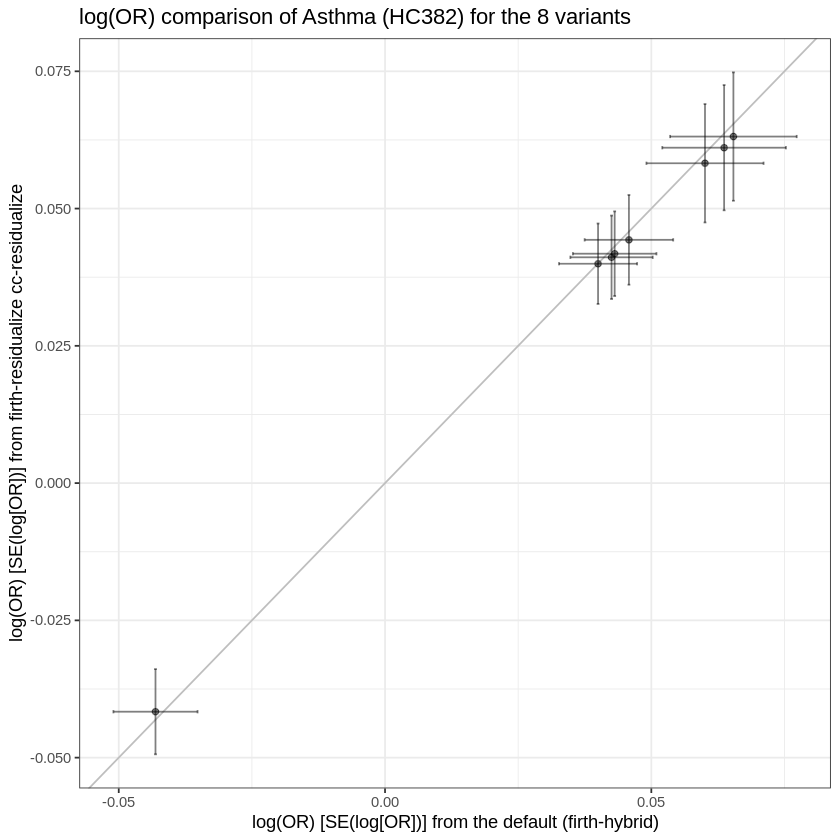

In [123]:
p1_8_vars_BETA_vs_BETA +
labs(
    title = 'log(OR) comparison of Asthma (HC382) for the 8 variants',
    x = 'log(OR) [SE(log[OR])] from the default (firth-hybrid)',
    y = 'log(OR) [SE(log[OR])] from firth-residualize cc-residualize'
)

In [124]:
ggsave(
    'p1.8_vars_BETA_vs_BETA.png',
    p1_8_vars_BETA_vs_BETA +
    labs(
        title = 'log(OR) comparison of Asthma (HC382) for the 8 variants',
        x = 'log(OR) [SE(log[OR])] from the default (firth-hybrid)',
        y = 'log(OR) [SE(log[OR])] from firth-residualize cc-residualize'
    )    
)

Saving 6.67 x 6.67 in image



## -log10(P) vs -log10(P) for the significant variants

In [135]:
lm(
    log10P_2 ~ log10P_1,
    df %>%
    filter(ERRCODE_1 == '.', ERRCODE_2 == '.') %>%
    filter(is_sig_1 | is_sig_2)
) %>%
summary()


Call:
lm(formula = log10P_2 ~ log10P_1, data = df %>% filter(ERRCODE_1 == 
    ".", ERRCODE_2 == ".") %>% filter(is_sig_1 | is_sig_2))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.06231  0.02362  0.03996  0.07454  1.00796 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 0.0194903  0.0100126    1.947   0.0517 .  
log10P_1    0.9942075  0.0004642 2141.830   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2589 on 1920 degrees of freedom
Multiple R-squared:  0.9996,	Adjusted R-squared:  0.9996 
F-statistic: 4.587e+06 on 1 and 1920 DF,  p-value: < 2.2e-16


In [136]:
lm(
    log10P_2 ~ 0 + log10P_1,
    df %>%
    filter(ERRCODE_1 == '.', ERRCODE_2 == '.') %>%
    filter(is_sig_1 | is_sig_2)
) %>%
summary()


Call:
lm(formula = log10P_2 ~ 0 + log10P_1, data = df %>% filter(ERRCODE_1 == 
    ".", ERRCODE_2 == ".") %>% filter(is_sig_1 | is_sig_2))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.10431  0.03653  0.05086  0.08186  0.96505 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)    
log10P_1 0.994937   0.000274    3631   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2591 on 1921 degrees of freedom
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9999 
F-statistic: 1.319e+07 on 1 and 1921 DF,  p-value: < 2.2e-16


In [130]:
p2_sig_p_vs_p <- df %>%
filter(ERRCODE_1 == '.', ERRCODE_2 == '.') %>%
filter(is_sig_1 | is_sig_2) %>%
ggplot(aes(x = log10P_1, y= log10P_2)) +
geom_abline(slope = 1, intercept=0, color='gray')+
geom_hline(yintercept = -log10(5e-8), color='gray')+
geom_vline(xintercept = -log10(5e-8), color='gray')+
geom_point(alpha=.05) +
theme_bw()

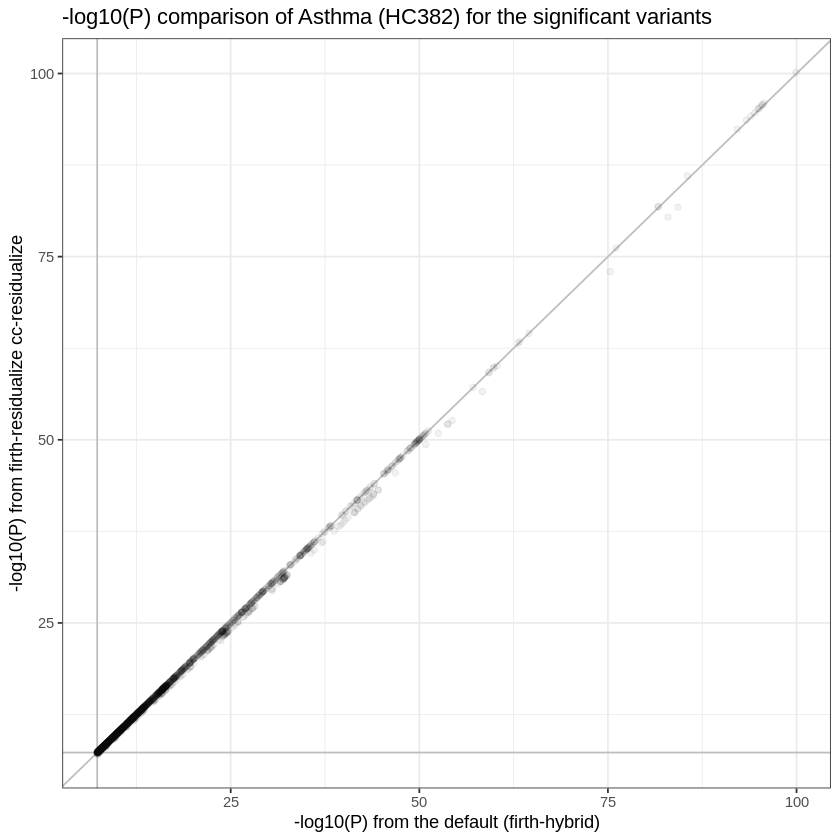

In [137]:
p2_sig_p_vs_p +
labs(
    title = '-log10(P) comparison of Asthma (HC382) for the significant variants',
    x = '-log10(P) from the default (firth-hybrid)',
    y = '-log10(P) from firth-residualize cc-residualize'
)

In [138]:
ggsave(
    'p2.sigs_P_vs_P.png',
    p2_sig_p_vs_p +
    labs(
        title = '-log10(P) comparison of Asthma (HC382) for the significant variants',
        x = '-log10(P) from the default (firth-hybrid)',
        y = '-log10(P) from firth-residualize cc-residualize'
    )
)

Saving 6.67 x 6.67 in image



## log(OR) vs log(OR) for the significant variants

In [139]:
lm(
    BETA_2 ~ BETA_1,
    df %>%
    filter(ERRCODE_1 == '.', ERRCODE_2 == '.') %>%
    filter(is_sig_1 | is_sig_2)
) %>%
summary()


Call:
lm(formula = BETA_2 ~ BETA_1, data = df %>% filter(ERRCODE_1 == 
    ".", ERRCODE_2 == ".") %>% filter(is_sig_1 | is_sig_2))

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0067295 -0.0003869  0.0002327  0.0003377  0.0061946 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.978e-06  2.410e-05    0.29    0.772    
BETA_1      9.936e-01  2.757e-04 3603.95   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001049 on 1920 degrees of freedom
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9999 
F-statistic: 1.299e+07 on 1 and 1920 DF,  p-value: < 2.2e-16


In [140]:
lm(
    BETA_2 ~ 0 + BETA_1,
    df %>%
    filter(ERRCODE_1 == '.', ERRCODE_2 == '.') %>%
    filter(is_sig_1 | is_sig_2)
) %>%
summary()


Call:
lm(formula = BETA_2 ~ 0 + BETA_1, data = df %>% filter(ERRCODE_1 == 
    ".", ERRCODE_2 == ".") %>% filter(is_sig_1 | is_sig_2))

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0067239 -0.0003793  0.0002391  0.0003441  0.0062033 

Coefficients:
        Estimate Std. Error t value Pr(>|t|)    
BETA_1 0.9936035  0.0002737    3630   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001049 on 1921 degrees of freedom
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9999 
F-statistic: 1.318e+07 on 1 and 1921 DF,  p-value: < 2.2e-16


In [143]:
p3_sig_BETA_vs_BETA <- df %>%
filter(ERRCODE_1 == '.', ERRCODE_2 == '.') %>%
filter(is_sig_1 | is_sig_2) %>%
ggplot(aes(x = BETA_1, y= BETA_2)) +
geom_abline(slope = 1, intercept=0, color='gray')+
geom_errorbarh(aes(xmin = BETA_1 - SE_1, xmax = BETA_1 + SE_1), alpha=.05) +
geom_errorbar( aes(ymin = BETA_2 - SE_2, ymax = BETA_2 + SE_2), alpha=.05) +
geom_point(alpha=.05) + 
theme_bw()

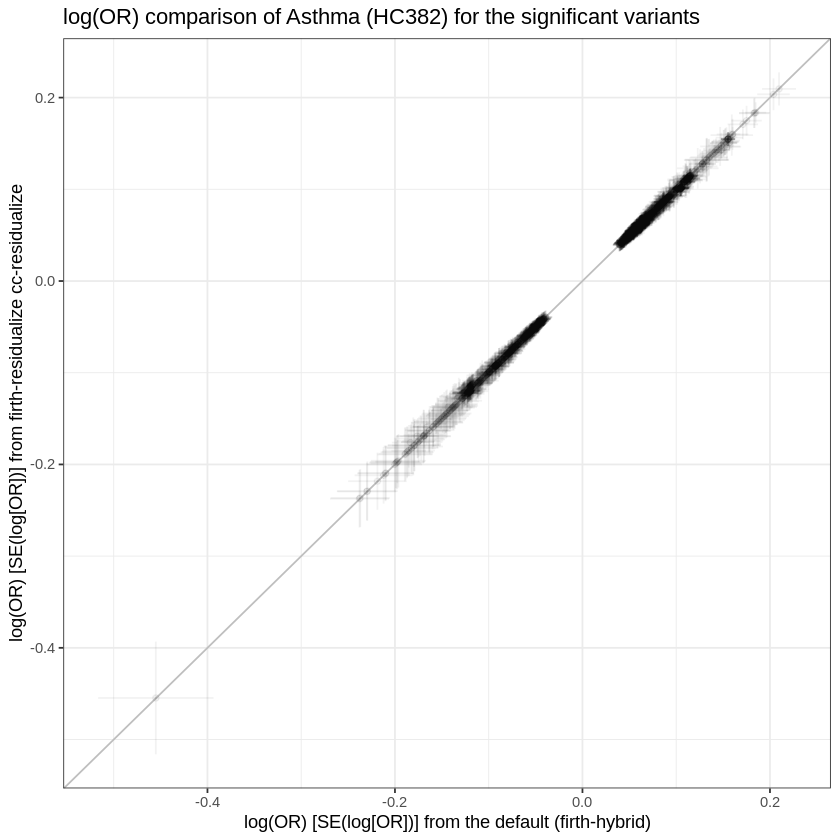

In [144]:
p3_sig_BETA_vs_BETA +
labs(
    title = 'log(OR) comparison of Asthma (HC382) for the significant variants',
    x = 'log(OR) [SE(log[OR])] from the default (firth-hybrid)',
    y = 'log(OR) [SE(log[OR])] from firth-residualize cc-residualize'
)

In [145]:
ggsave(
    'p3.sigs_BETA_vs_BETA.png',
    p3_sig_BETA_vs_BETA +
    labs(
        title = 'log(OR) comparison of Asthma (HC382) for the significant variants',
        x = 'log(OR) [SE(log[OR])] from the default (firth-hybrid)',
        y = 'log(OR) [SE(log[OR])] from firth-residualize cc-residualize'
    )
)

Saving 6.67 x 6.67 in image



## p-value comparison for the full sumstats

In [146]:
lm(
    log10P_2 ~ log10P_1,
    df %>%
    filter(ERRCODE_1 == '.', ERRCODE_2 == '.')
) %>%
summary()


Call:
lm(formula = log10P_2 ~ log10P_1, data = df %>% filter(ERRCODE_1 == 
    ".", ERRCODE_2 == "."))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.20845 -0.00208 -0.00129  0.00013  1.02362 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.431e-03  1.989e-05   122.2   <2e-16 ***
log10P_1    9.961e-01  1.700e-05 58603.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01816 on 994919 degrees of freedom
Multiple R-squared:  0.9997,	Adjusted R-squared:  0.9997 
F-statistic: 3.434e+09 on 1 and 994919 DF,  p-value: < 2.2e-16


In [147]:
lm(
    log10P_2 ~ 0+log10P_1,
    df %>%
    filter(ERRCODE_1 == '.', ERRCODE_2 == '.')
) %>%
summary()


Call:
lm(formula = log10P_2 ~ 0 + log10P_1, data = df %>% filter(ERRCODE_1 == 
    ".", ERRCODE_2 == "."))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.27664  0.00024  0.00090  0.00207  1.02223 

Coefficients:
          Estimate Std. Error t value Pr(>|t|)    
log10P_1 9.970e-01  1.567e-05   63624   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01829 on 994920 degrees of freedom
Multiple R-squared:  0.9998,	Adjusted R-squared:  0.9998 
F-statistic: 4.048e+09 on 1 and 994920 DF,  p-value: < 2.2e-16


## BETA comparison for the full sumstats

In [148]:
lm(
    BETA_2 ~ BETA_1,
    df %>%
    filter(ERRCODE_1 == '.', ERRCODE_2 == '.')
) %>%
summary()


Call:
lm(formula = BETA_2 ~ BETA_1, data = df %>% filter(ERRCODE_1 == 
    ".", ERRCODE_2 == "."))

Residuals:
   Min     1Q Median     3Q    Max 
-2.765  0.000  0.000  0.000 32.458 

Coefficients:
             Estimate Std. Error   t value Pr(>|t|)    
(Intercept) 3.470e-04  4.151e-05     8.359   <2e-16 ***
BETA_1      1.004e+00  7.329e-05 13698.395   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0394 on 994919 degrees of freedom
Multiple R-squared:  0.9947,	Adjusted R-squared:  0.9947 
F-statistic: 1.876e+08 on 1 and 994919 DF,  p-value: < 2.2e-16


In [149]:
lm(
    BETA_2 ~ 0 + BETA_1,
    df %>%
    filter(ERRCODE_1 == '.', ERRCODE_2 == '.')
) %>%
summary()


Call:
lm(formula = BETA_2 ~ 0 + BETA_1, data = df %>% filter(ERRCODE_1 == 
    ".", ERRCODE_2 == "."))

Residuals:
   Min     1Q Median     3Q    Max 
-2.764  0.000  0.000  0.000 32.458 

Coefficients:
        Estimate Std. Error t value Pr(>|t|)    
BETA_1 1.004e+00  6.975e-05   14397   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0394 on 994920 degrees of freedom
Multiple R-squared:  0.9952,	Adjusted R-squared:  0.9952 
F-statistic: 2.073e+08 on 1 and 994920 DF,  p-value: < 2.2e-16
